# CS 582 Coding Assignment 1

This notebook contains the code and analysis for analyzing the SciPlex dataset for perturbation prediction.

In [1]:
# Python standard library imports
import os
from random import seed
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Pytorch and Pytorch Geometric libraries
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import GraphSAINTRandomWalkSampler

# Libraries for single-cell analysis
import anndata
import scanpy as sc

/vast/palmer/home.mccleary/sr2464/.conda/envs/pyg_torch2.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
RANDOM_SEED = 1234
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# View all columns of Pandas DataFrames:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Project Overview

In this project, we explore perturbation prediction in single-cell RNA sequencing (scRNAseq) data using Graph Neural Networks (GNNs) and explainability frameworks. The goal will be to perform accurate **perturbation prediction**, where we train a deep learning model, specifically a GNN, to predict the drug perturbation which was applied to a given cell based on its gene expression. Furthermore, in order to identify genes which contributed to or are responsible for model predictions, we utilize GNN explainability frameworks in order to explain GNN predictions and identify important features, nodes, and edges in the input graph. Additional discussion for the rationale of using GNNs for modeling single-cell data, as well as methodology are documented throughout this notebook.

Concretely, the goals will be to:
1. Train a Graph Neural Network to do drug perturbation prediction on scRNAseq data
2. Implement a GNN explainability framework to explain model predictions
3. Analyze important genes which factor into GNN predictions for specific drugs

The dataset we will be using will be the SciPlex dataset [1], which is a scRNAseq screening dataset consisting of 188 drug compounds applied to three different cell lines across thousands of samples. The sci-Plex methodology itself which enables the massive perturbational screening involves oligo nuclear hashing, which helps to quantify transcriptional responses to numerous independent perturbations at single-cell resolution. For the scope of this project, we will be using the A549 cancer cell line, which is a cell line of lung alveolus epithelial cells.

References:
1. Srivatsan, Sanjay R., et al. "Massively multiplex chemical transcriptomics at single-cell resolution." Science 367.6473 (2020): 45-51.

# Load Data

There are three cancerous cell lines in the sciPlex dataset: A549 (lung alveolus epithelial cells), K562 (cultured cells), and MCF7 (mammary gland).

We start by loading the annotated data object (anndata object) for the A549 cancer cell line. We see that it has many cell metadata and annotations in the .obs DataFrame, as well as information about the genomic features in the .var attribute.

In [5]:
PATH = "/home/sr2464/palmer_scratch/CS582_Coding_Assignment/SciPlexData/A549_lung_alveolus_epithelial_cell_culture.h5ad"
adata = anndata.read_h5ad(PATH)
adata

AnnData object with n_obs × n_vars = 143015 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [6]:
adata.obs.head()

,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,hash_umis_P,pval_P,qval_P,top_to_second_best_ratio_P,rt_well,lig_well,pcr_well,pcr_plate,rt_plate,lig_plate,Combo,well_oligo,plate_oligo,replicate,time_point,drug_dose,catalog_number,vehicle,dose_pattern,dose,pathway_level_1,pathway_level_2,product_name,target,pathway,product_dose,viability,num_genes_expressed,g1s_score,g2m_score,proliferation_index,Cluster,louvain_component,disease_ontology_term_id,donor_id,assay_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
A01_E09_RT_BC_100_Lig_BC_245,Chem3_Screen2,2.296651,3094,373,0.0,0.0,52.807724,209,0.000000e+00,0.000000e+00,56.814318,100,245,A01,E09,2,3,plate9_C3plate39,plate9_C3,plate39,rep2,24,S1055_2,S1055,False,2,1000,PKC signaling,PKC activitiy,Enzastaurin (LY317615),PKC,TGF-beta/Smad,Enzastaurin (LY317615)_1000,0.999924,1571,1.155964,2.475312,2.643512,1,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,+pQibXbkV6
A01_E09_RT_BC_100_Lig_BC_306,Chem3_Screen2,0.480141,646,23,0.0,0.0,10.053193,25,1.067310e-191,8.485111e-189,19.800273,100,306,A01,E09,2,4,plate10_D6plate40,plate10_D6,plate40,rep2,24,S1192_4,S1192,False,4,10,DNA damage & DNA repair,Nucleotide analog,Raltitrexed,DNA/RNA Synthesis,DNA Damage,Raltitrexed_10,0.997575,417,0.000000,1.980748,1.980748,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,5A~&6zx%%T
A01_E09_RT_BC_101_Lig_BC_109,Chem3_Screen2,0.516561,695,93,0.0,0.0,27.803759,117,0.000000e+00,0.000000e+00,43.313841,101,109,A01,E09,2,2,plate6_G5plate12,plate6_G5,plate12,rep1,24,S0002_3,S0000,True,3,0,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle_0,1.000000,421,0.000000,0.000000,0.000000,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,pGI4g(d5me
A01_E09_RT_BC_101_Lig_BC_229,Chem3_Screen2,0.387978,523,75,0.0,0.0,63.947847,101,0.000000e+00,0.000000e+00,1886.909392,101,229,A01,E09,2,3,plate8_C5plate38,plate8_C5,plate38,rep2,24,S1029_4,S1029,False,4,10,Protein folding & Protein degradation,E3 ubiquitin ligase activity,Lenalidomide (CC-5013),TNF-alpha,Apoptosis,Lenalidomide (CC-5013)_10,0.999966,428,1.817254,2.801225,3.073606,7,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,G)G1o2fD<U
A01_E09_RT_BC_101_Lig_BC_280,Chem3_Screen2,0.724671,976,102,0.0,0.0,25.832608,127,0.000000e+00,0.000000e+00,475.679099,101,280,A01,E09,2,3,plate3_G1plate33,plate3_G1,plate33,rep2,24,S1703_2,S1703,False,2,1000,Epigenetic regulation,Histone deacetylation,Divalproex Sodium,HDAC,Ubiquitin,Divalproex Sodium_1000,0.953656,714,1.637016,0.867074,1.874835,10,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,gY;lI#JE~o


In [7]:
Counter(adata.obs["cell_type"])

Counter({'cultured cell': 143015})

In [8]:
drug_perturbations_counter = Counter(adata.obs["product_name"])
print(len(drug_perturbations_counter))  # 189 drug compounds
drug_perturbations_counter

189


Counter({'Enzastaurin (LY317615)': 687,
         'Raltitrexed': 707,
         'Vehicle': 3287,
         'Lenalidomide (CC-5013)': 844,
         'Divalproex Sodium': 546,
         'MLN8054': 429,
         'Sodium Phenylbutyrate': 937,
         'Celecoxib': 802,
         'Linifanib (ABT-869)': 891,
         'Thalidomide': 780,
         'SNS-314': 528,
         '(+)-JQ1': 683,
         'S3I-201': 860,
         'AZD1480': 661,
         'PF-573228': 660,
         'CEP-33779': 894,
         'Resminostat': 750,
         'Tie2 kinase inhibitor': 905,
         'Nintedanib (BIBF 1120)': 947,
         'SRT3025 HCl': 549,
         'Avagacestat (BMS-708163)': 814,
         'Quisinostat (JNJ-26481585) 2HCl': 477,
         'MC1568': 713,
         'Temsirolimus (CCI-779, NSC 683864)': 559,
         'IOX2': 902,
         'Bosutinib (SKI-606)': 899,
         'Regorafenib (BAY 73-4506)': 761,
         'Aurora A Inhibitor I': 632,
         'ENMD-2076': 759,
         'Curcumin': 870,
         'NVP-BSK805 2

In [9]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
feature_id,,,,,
ENSG00000278340,False,MIR6862-2,NCBITaxon:9606,gene,70
ENSG00000205328,False,OR6C65,NCBITaxon:9606,gene,939
ENSG00000237481,False,RP4-803J11.2,NCBITaxon:9606,gene,640
ENSG00000228118,False,MYL6P5,NCBITaxon:9606,gene,459
ENSG00000248245,False,CTB-49A3.2,NCBITaxon:9606,gene,816


In [10]:
# Switch index of .var attribute to gene names, make sure all gene names are capitalized
adata.var["gene_names"] = adata.var["feature_name"].astype(str).copy()
adata.var["gene_names"] = adata.var["gene_names"].apply(lambda x: x.upper())
adata.var["Ensembl_IDs"] = adata.var.index.copy()
adata.var.index = adata.var["gene_names"]

In [11]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,gene_names,Ensembl_IDs
gene_names,,,,,,,
MIR6862-2,False,MIR6862-2,NCBITaxon:9606,gene,70,MIR6862-2,ENSG00000278340
OR6C65,False,OR6C65,NCBITaxon:9606,gene,939,OR6C65,ENSG00000205328
RP4-803J11.2,False,RP4-803J11.2,NCBITaxon:9606,gene,640,RP4-803J11.2,ENSG00000237481
MYL6P5,False,MYL6P5,NCBITaxon:9606,gene,459,MYL6P5,ENSG00000228118
CTB-49A3.2,False,CTB-49A3.2,NCBITaxon:9606,gene,816,CTB-49A3.2,ENSG00000248245


In [12]:
adata.var.dtypes

feature_is_filtered        bool
feature_name           category
feature_reference      category
feature_biotype        category
feature_length         category
gene_names               object
Ensembl_IDs              object
dtype: object

In [13]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

Looking a bit more closely, we can see that the data has 143015 cells and 55773 genes. The cell x gene matrix, stored in the .X attribute, contains raw counts, which are integers representing how many RNA transcripts were captured for that gene in that particular cell.

In [14]:
adata

AnnData object with n_obs × n_vars = 143015 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [15]:
adata.X.data[:10]  # Raw integer counts of RNA transcripts

array([1., 1., 1., 1., 1., 4., 1., 1., 1., 1.], dtype=float32)

# Data preprocessing and visualization

Since the data we loaded is unprocessed, we will need to perform standard filtering and normalization steps in order to preprocess the scRNAseq data before we can train Machine Learning models on it. We will follow a great preprocessing and data visualization guide from the Scanpy library:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [16]:
# Basic filtering of cells with too few genes expressed and genes expressed in too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [17]:
adata  # We can see that a few cells and a few thousand genes were filtered out

AnnData object with n_obs × n_vars = 142944 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [18]:
# Filtering cells by statistics about mitochondrial gene counts. Follows intuition that healthy cells should not have
# a high proportion of counts coming from mitochondrial genes
#  annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [19]:
adata

AnnData object with n_obs × n_vars = 142944 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

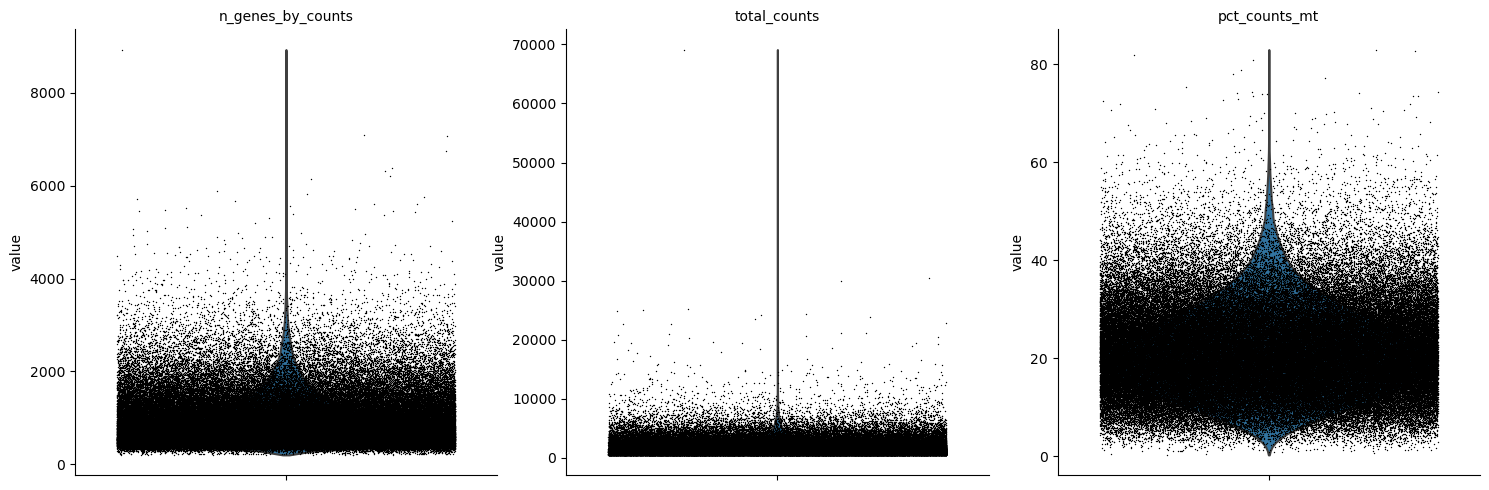

In [20]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

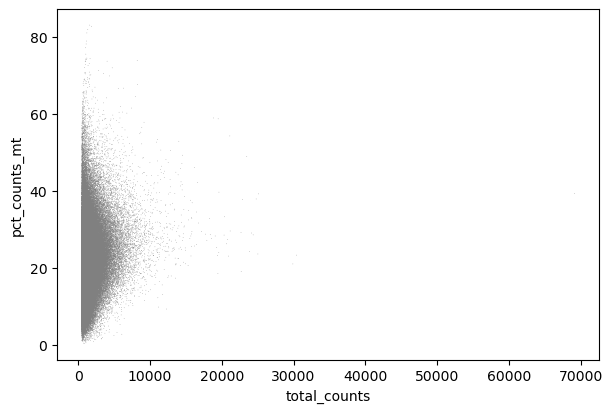

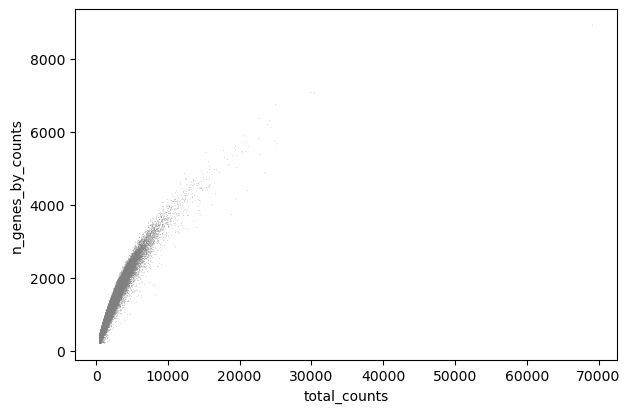

In [21]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

From the plots, we can see that there are outlier cells which have n_genes_by_counts > 4000, and which have over 60 percent of their counts coming from mitochondrial genes, which is too high for normal cells. We therefore filter them out.

In [22]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 60, :].copy()

In [23]:
adata

AnnData object with n_obs × n_vars = 142630 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

Now we normalize all counts to sum up to 10000 for all cells, so that counts become comparable across cells

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [25]:
adata.X.data.shape

(133751800,)

A quick peek at the nonzero values in our data tells us that things are heavily exponentially distributed, so we do a log normalization on the entire cell x gene matrix. We do log1p so that zero counts stay as zero after the log transformation.

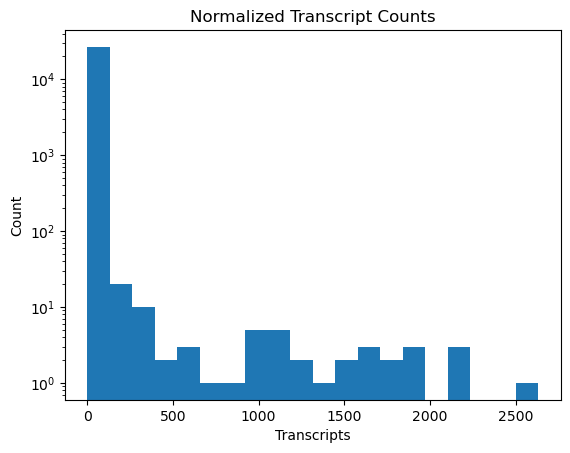

In [26]:
plt.hist(adata.X.data[::5000], bins=20)
plt.title("Normalized Transcript Counts")
plt.xlabel("Transcripts")
plt.ylabel("Count")
plt.yscale("log")
plt.show()
plt.close()

In [27]:
sc.pp.log1p(adata)

Our data is now in a better range after log transformation, however it is still not in a great range for neural networks. We add on an additional step here of min-max normalization to bring the expression into range [0, 1].

We know, however, that there can be outlier values in the expression, as seen in our filtering steps. We want the majority of our data to fall into the [0,1] range with good density, so we can normalize by the 99.9th percentile rather than the 100th percentile, so that outliers do not push our value range to become too small.

In [28]:
print(adata.X.max())
print(adata.X.min())

8.482397
0.0


In [29]:
ninety_ninth = np.percentile(adata.X.data, 99.0)
print("ninety_ninth:", ninety_ninth)
print("max value:", adata.X.data.max())

ninety_ninth: 3.7480080127716064
max value: 8.482397


In [30]:
# adata.X is a sparse matrix, and the minimum value in the matrix is 0, so it will be sufficient to divide the .data attribute of the 
#  sparse matrix in order to scale into relative [0, 1] range
adata.X.data /= ninety_ninth
print("max value:", adata.X.data.max())

max value: 2.2631748


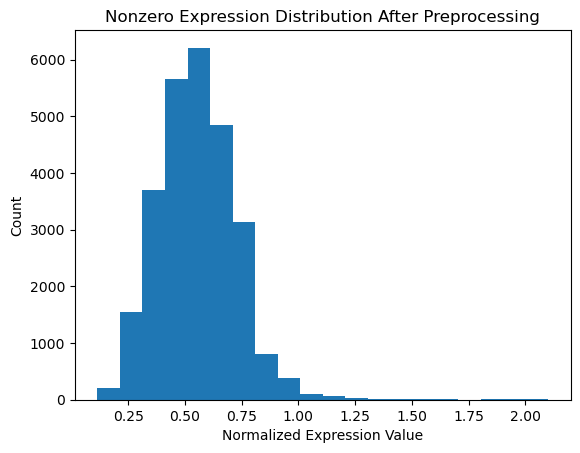

In [31]:
plt.hist(adata.X.data[::5000], bins=20)
plt.title("Nonzero Expression Distribution After Preprocessing")
plt.xlabel("Normalized Expression Value")
plt.ylabel("Count")
plt.show()
plt.close()

We can see that after our preprocessing steps, we have a nice normal distribution of values prmarily in the range [0, 1], but not biased by outliers. This will be good as input for our GNN later on. We will save the preprocessed anndata object in a specific variable for later input into our GNN model. The adata we have currently will continue to be modified for visualization purposes.

In [32]:
preprocessed_adata_cp10k_log1p_minmax = adata.copy()
preprocessed_adata_cp10k_log1p_minmax

AnnData object with n_obs × n_vars = 142630 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

We now continue with the Scanpy tutorial, which contains a few more useful visualization and calculation steps

In [33]:
# Finding highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

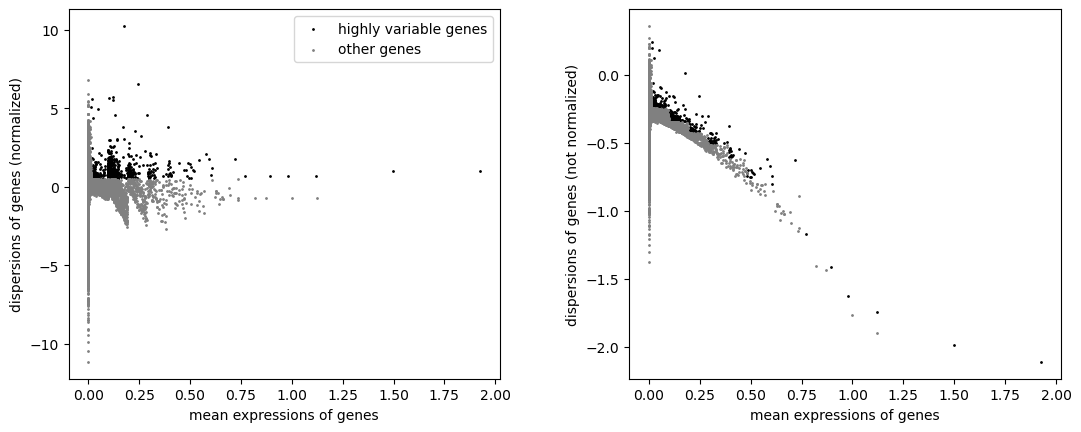

In [34]:
sc.pl.highly_variable_genes(adata)

In [35]:
# For visualization, we will be plotting things only using highly variable genes. Filter to HVGs here:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 142630 × 855
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', '

In [36]:
# Here we regress out the effects of total_counts and mitochondrial gene percentage expressed, and we scale the
#  data to zero mean and unit variance before computing PCA
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

In [37]:
# Calculate PCA on data
sc.tl.pca(adata, svd_solver="arpack")
# sc.pl.pca_variance_ratio(adata, log=False)  # To examine variance explained ratio

In [38]:
# Compute a neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

Here we plot a UMAP of the data, colored by drug perturbation compound

In [39]:
sc.tl.umap(adata)

/vast/palmer/home.mccleary/sr2464/.conda/envs/pyg_torch2.1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


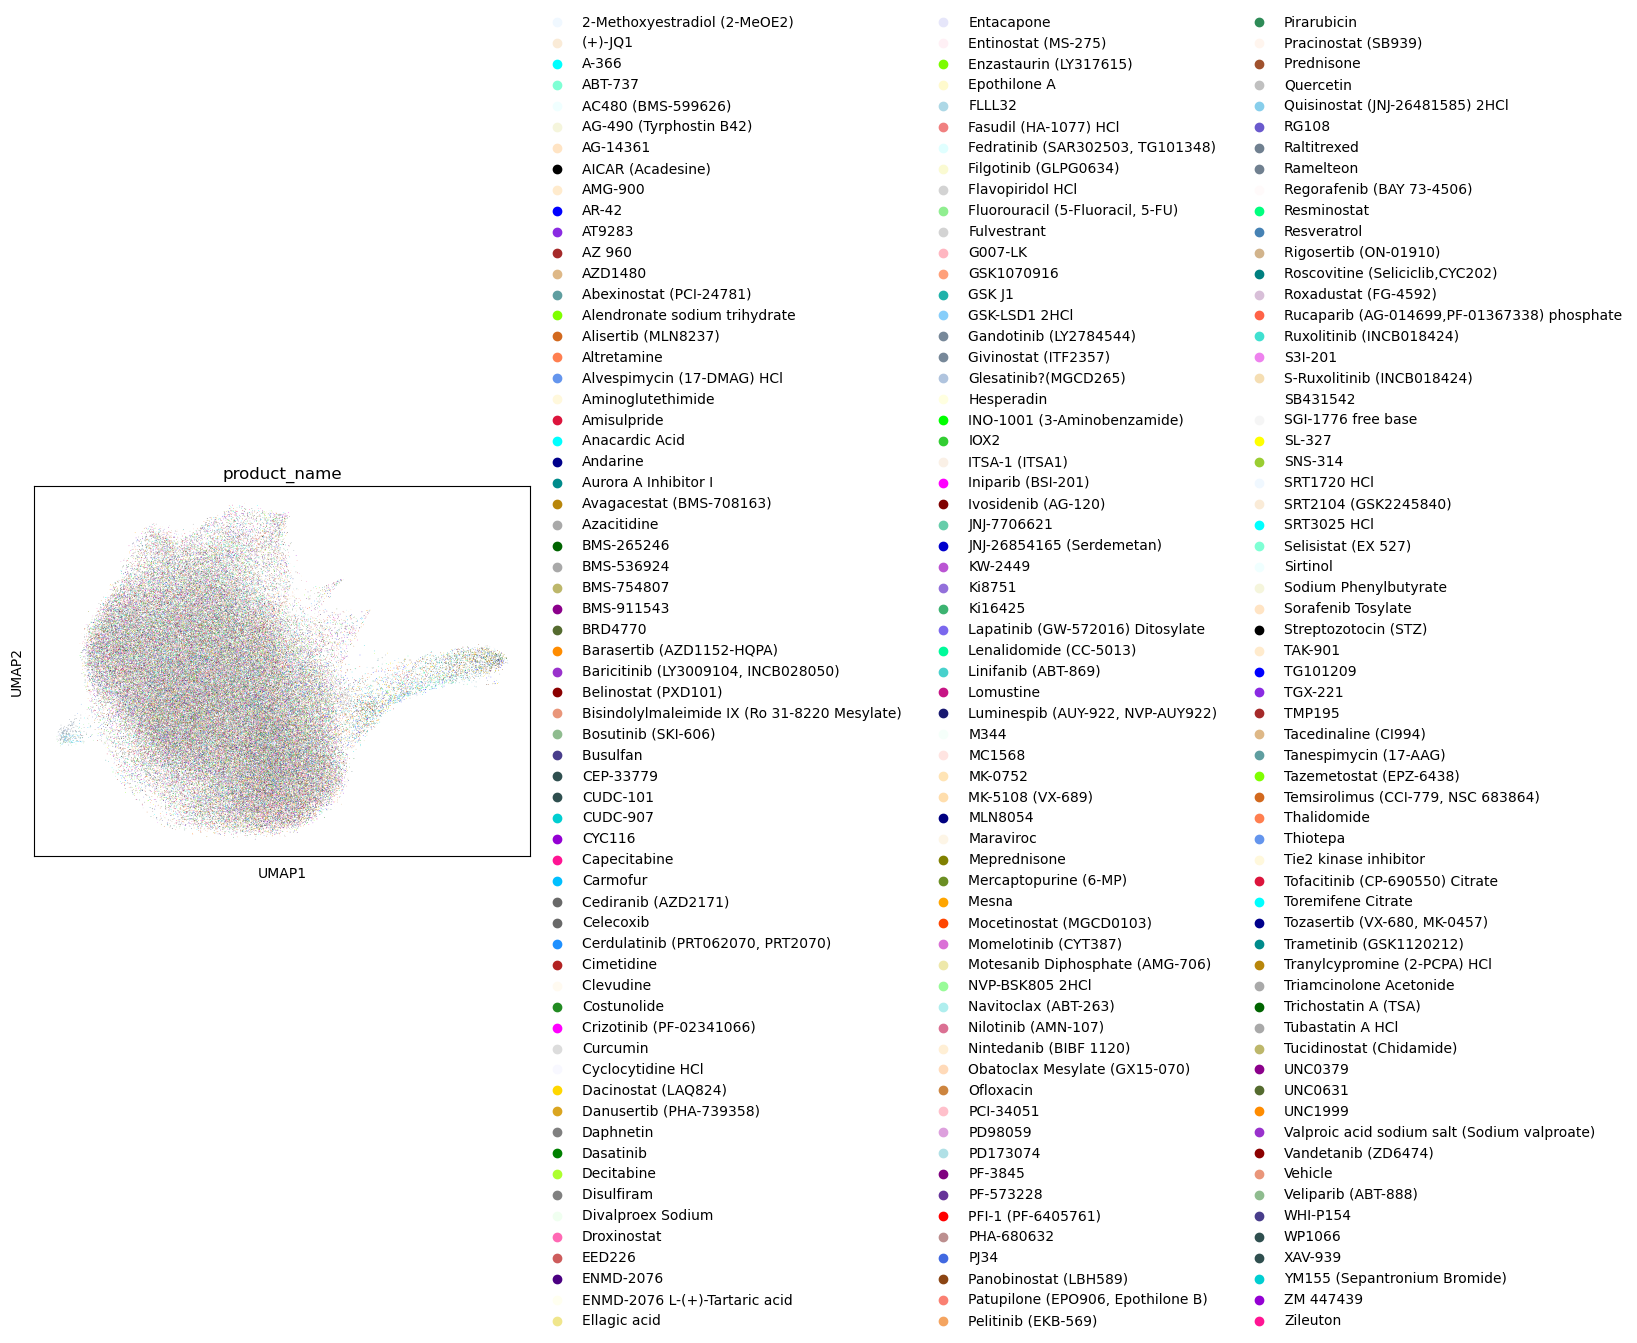

In [40]:
sc.pl.umap(adata, color="product_name", palette=list(matplotlib.colors.CSS4_COLORS.values()))

# Model Development

In this section, we define our Graph Neural Network along with dataloaders, training loops, and other training utilities.

Motivation for using Graph Neural Networks:
- GNNs are a Deep Learning architecture which operates over graph-structured data, which in the context of single-cell sequencing data means a graph composed of nodes which represent cells and edges which represent connections between cells. In a spatial transcriptomics dataset, the edges might come from the 2D spatial graph given by the spatial sequencing method, however in regular scRNAseq data we can construct a K-nearest neighbors graph based on expression similarity between cells to get a graph structure.
- In scRNASseq data, cell measurements are sparse and noisy due to the nature of the sequencing technology. The benefit of using GNNs is that in a K-neighbors graph, a given cell will have its signal reinforced by similar cells in the dataset based on the construction of the K-neighbors graph. In a spatial dataset, the graph structure would be modeling real-world spatial structure, which also comes with benefits for modeling the data according to its natural structure.
- In addition to operating over a flexible representation of data, GNNs also have explainability frameworks such as GNNExplainer [1] and PGM-Explainer [2], which aim to produce explanations for trained GNN models over arbitrary input graphs. This is useful for explaining predictions and doing feature attribution on data that has domain-specific node and edge entities, which is what we will be implementing in this assignment.

References:
1. Ying, Zhitao, et al. "Gnnexplainer: Generating explanations for graph neural networks." Advances in neural information processing systems 32 (2019).
2. Vu, Minh, and My T. Thai. "Pgm-explainer: Probabilistic graphical model explanations for graph neural networks." Advances in neural information processing systems 33 (2020): 12225-12235.

### Preparation for training

We now prepare the dataloader and utilities for training our GNN for perturbation prediction. First, we need to construct a N-neighbors graph from our processed adata object, and convert the perturbation compound names into integer labels

In [41]:
preprocessed_adata_cp10k_log1p_minmax

AnnData object with n_obs × n_vars = 142630 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [42]:
sc.tl.pca(preprocessed_adata_cp10k_log1p_minmax, svd_solver="arpack", n_comps=200)
sc.pp.neighbors(preprocessed_adata_cp10k_log1p_minmax, n_neighbors=5, n_pcs=200)

In [43]:
print(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].dtype)
print(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].shape)

float32
(142630, 142630)


In [44]:
total_edge_index, total_edge_attr = dense_to_sparse(torch.from_numpy(preprocessed_adata_cp10k_log1p_minmax.obsp["connectivities"].toarray()))
print(total_edge_index.shape)
print(total_edge_attr.shape)

torch.Size([2, 1122930])
torch.Size([1122930])


Here, we make a column of integer labels corresponding to the 189 drug perturbations applied to different cells

In [45]:
preprocessed_adata_cp10k_log1p_minmax.obs.head()

,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,hash_umis_P,pval_P,qval_P,top_to_second_best_ratio_P,rt_well,lig_well,pcr_well,pcr_plate,rt_plate,lig_plate,Combo,well_oligo,plate_oligo,replicate,time_point,drug_dose,catalog_number,vehicle,dose_pattern,dose,pathway_level_1,pathway_level_2,product_name,target,pathway,product_dose,viability,num_genes_expressed,g1s_score,g2m_score,proliferation_index,Cluster,louvain_component,disease_ontology_term_id,donor_id,assay_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
A01_E09_RT_BC_100_Lig_BC_245,Chem3_Screen2,2.296651,3094,373,0.0,0.0,52.807724,209,0.000000e+00,0.000000e+00,56.814318,100,245,A01,E09,2,3,plate9_C3plate39,plate9_C3,plate39,rep2,24,S1055_2,S1055,False,2,1000,PKC signaling,PKC activitiy,Enzastaurin (LY317615),PKC,TGF-beta/Smad,Enzastaurin (LY317615)_1000,0.999924,1571,1.155964,2.475312,2.643512,1,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,+pQibXbkV6,1566,1566,3078.0,874.0,28.395063
A01_E09_RT_BC_100_Lig_BC_306,Chem3_Screen2,0.480141,646,23,0.0,0.0,10.053193,25,1.067310e-191,8.485111e-189,19.800273,100,306,A01,E09,2,4,plate10_D6plate40,plate10_D6,plate40,rep2,24,S1192_4,S1192,False,4,10,DNA damage & DNA repair,Nucleotide analog,Raltitrexed,DNA/RNA Synthesis,DNA Damage,Raltitrexed_10,0.997575,417,0.000000,1.980748,1.980748,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,5A~&6zx%%T,415,415,642.0,172.0,26.791277
A01_E09_RT_BC_101_Lig_BC_109,Chem3_Screen2,0.516561,695,93,0.0,0.0,27.803759,117,0.000000e+00,0.000000e+00,43.313841,101,109,A01,E09,2,2,plate6_G5plate12,plate6_G5,plate12,rep1,24,S0002_3,S0000,True,3,0,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle_0,1.000000,421,0.000000,0.000000,0.000000,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,pGI4g(d5me,419,419,692.0,208.0,30.057802
A01_E09_RT_BC_101_Lig_BC_229,Chem3_Screen2,0.387978,523,75,0.0,0.0,63.947847,101,0.000000e+00,0.000000e+00,1886.909392,101,229,A01,E09,2,3,plate8_C5plate38,plate8_C5,plate38,rep2,24,S1029_4,S1029,False,4,10,Protein folding & Protein degradation,E3 ubiquitin ligase activity,Lenalidomide (CC-5013),TNF-alpha,Apoptosis,Lenalidomide (CC-5013)_10,0.999966,428,1.817254,2.801225,3.073606,7,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,G)G1o2fD<U,425,425,517.0,45.0,8.704062
A01_E09_RT_BC_101_Lig_BC_280,Chem3_Screen2,0.724671,976,102,0.0,0.0,25.832608,127,0.000000e+00,0.000000e+00,475.679099,101,280,A01,E09,2,3,plate3_G1plate33,plate3_G1,plate33,rep2,24,S1703_2,S1703,False,2,1000,Epigenetic regulation,Histone deacetylation,Divalproex Sodium,HDAC,Ubiquitin,Divalproex Sodium_1000,0.953656,714,1.637016,0.867074,1.874835,10,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,gY;lI#JE~o,712,712,971.0,104.0,10.710608


In [46]:
unique_drug_perturbations = list(set(preprocessed_adata_cp10k_log1p_minmax.obs["product_name"].tolist()))
unique_drug_perturbations.sort(key=str.lower)
print(len(unique_drug_perturbations))
unique_drug_perturbations[:10]

189


['(+)-JQ1',
 '2-Methoxyestradiol (2-MeOE2)',
 'A-366',
 'Abexinostat (PCI-24781)',
 'ABT-737',
 'AC480 (BMS-599626)',
 'AG-14361',
 'AG-490 (Tyrphostin B42)',
 'AICAR (Acadesine)',
 'Alendronate sodium trihydrate']

In [47]:
drug_pert_to_int_label = {}
for drug_pert_name in unique_drug_perturbations:
    drug_pert_to_int_label[drug_pert_name] = len(drug_pert_to_int_label)

In [48]:
drug_pert_to_int_label

{'(+)-JQ1': 0,
 '2-Methoxyestradiol (2-MeOE2)': 1,
 'A-366': 2,
 'Abexinostat (PCI-24781)': 3,
 'ABT-737': 4,
 'AC480 (BMS-599626)': 5,
 'AG-14361': 6,
 'AG-490 (Tyrphostin B42)': 7,
 'AICAR (Acadesine)': 8,
 'Alendronate sodium trihydrate': 9,
 'Alisertib (MLN8237)': 10,
 'Altretamine': 11,
 'Alvespimycin (17-DMAG) HCl': 12,
 'AMG-900': 13,
 'Aminoglutethimide ': 14,
 'Amisulpride': 15,
 'Anacardic Acid': 16,
 'Andarine': 17,
 'AR-42': 18,
 'AT9283': 19,
 'Aurora A Inhibitor I': 20,
 'Avagacestat (BMS-708163)': 21,
 'AZ 960': 22,
 'Azacitidine ': 23,
 'AZD1480': 24,
 'Barasertib (AZD1152-HQPA)': 25,
 'Baricitinib (LY3009104, INCB028050)': 26,
 'Belinostat (PXD101)': 27,
 'Bisindolylmaleimide IX (Ro 31-8220 Mesylate)': 28,
 'BMS-265246': 29,
 'BMS-536924': 30,
 'BMS-754807': 31,
 'BMS-911543': 32,
 'Bosutinib (SKI-606)': 33,
 'BRD4770': 34,
 'Busulfan ': 35,
 'Capecitabine ': 36,
 'Carmofur': 37,
 'Cediranib (AZD2171)': 38,
 'Celecoxib': 39,
 'CEP-33779': 40,
 'Cerdulatinib (PRT062070,

In [49]:
preprocessed_adata_cp10k_log1p_minmax.obs["drug_perturbation_int_label"] = preprocessed_adata_cp10k_log1p_minmax.obs["product_name"].map(drug_pert_to_int_label)
preprocessed_adata_cp10k_log1p_minmax.obs[["sample", "product_name", "drug_perturbation_int_label"]].head()

,sample,product_name,drug_perturbation_int_label
A01_E09_RT_BC_100_Lig_BC_245,Chem3_Screen2,Enzastaurin (LY317615),65
A01_E09_RT_BC_100_Lig_BC_306,Chem3_Screen2,Raltitrexed,131
A01_E09_RT_BC_101_Lig_BC_109,Chem3_Screen2,Vehicle,181
A01_E09_RT_BC_101_Lig_BC_229,Chem3_Screen2,Lenalidomide (CC-5013),93
A01_E09_RT_BC_101_Lig_BC_280,Chem3_Screen2,Divalproex Sodium,57


In [50]:
cell_labels = torch.tensor(preprocessed_adata_cp10k_log1p_minmax.obs["drug_perturbation_int_label"].tolist(), dtype=torch.int64)
print(cell_labels.shape)
cell_labels[:10]

torch.Size([142630])


tensor([ 65, 131, 181,  93,  57, 105, 150,  39,  94, 163])

Create a PyG graph object from the anndata, and split the data into train, val, and test using the RandomNodeSplit() utility function from Pytorch Geometric

In [51]:
gene_expression_matrix = preprocessed_adata_cp10k_log1p_minmax.X.toarray()
gene_expression_matrix.shape

(142630, 33015)

In [52]:
full_data_graph = Data(
    x=torch.from_numpy(gene_expression_matrix),
    edge_index=total_edge_index,
    edge_attr=total_edge_attr,
    y=cell_labels,
    num_nodes=gene_expression_matrix.shape[0]
)
full_data_graph

Data(x=[142630, 33015], edge_index=[2, 1122930], edge_attr=[1122930], y=[142630], num_nodes=142630)

In [53]:
transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
full_data_graph = transform(full_data_graph)
full_data_graph

Data(x=[142630, 33015], edge_index=[2, 1122930], edge_attr=[1122930], y=[142630], num_nodes=142630, train_mask=[142630], val_mask=[142630], test_mask=[142630])

In [54]:
print(full_data_graph.train_mask.sum())
print(full_data_graph.val_mask.sum())
print(full_data_graph.test_mask.sum())

tensor(99841)
tensor(14263)
tensor(28526)


Define GraphSAINT subgraph dataloader, for batched training

In [55]:
loader = GraphSAINTRandomWalkSampler(
    full_data_graph, 
    batch_size=1000,  # Number of random walks conducted per subgraph sampled 
    walk_length=2,  # Length of random walk. Using default from PyG GraphSAINT tutorial/GraphSAINT paper
    num_steps=100,  # number of minibatch subgraphs in one epoch
    sample_coverage=100,  # Used for calculating normalization statistics at initialization of GraphSAINT loader
    log=False
)
# Note that the loader will return subgraphs which will contain train, val, and test nodes. Train/val/test computations
#  will be split from each other in the training loop when loss and metrics are calculated

## GNN Model Definition

Here, we define our Graph Neural Network architecture for perturbation prediction. We define a GNN with two layers, which will perform two rounds message-passing across edges in the input graph. We do not want to make the GNN much deeper than two layers since this will lead to ovesmoothing (convergence) of node representations, making them indistinguishable from each other. We want each node embedding ideally to capture local neighborhood information for each cell in order to achieve good classification performance on drug perturbations per cell.

In [65]:
class MLP(nn.Module):
    def __init__(self, in_features: int, hidden_dim: int, out_features: int, dropout_rate: float):
        super().__init__()
        self.lin1 = nn.Linear(in_features, hidden_dim)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.lin2 = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        x = self.lin1(x)
        x = self.drop1(x)
        x = nn.functional.leaky_relu(x)
        x = self.lin2(x)
        return x

class GAT(torch.nn.Module):
    def __init__(self, num_node_features: int, hidden_dim: int, output_dim: int, num_attn_heads: int, dropout: float, attn_dropout: float):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(
            in_channels=num_node_features, 
            out_channels=hidden_dim, 
            heads=num_attn_heads, 
            dropout=attn_dropout, 
            concat=True
        )
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=dropout)
        self.conv2 = GATConv(
            in_channels=hidden_dim * num_attn_heads, 
            out_channels=hidden_dim, 
            heads=1, 
            dropout=attn_dropout, 
            concat=False
        )
        self.lin_out = MLP(
            in_features=hidden_dim,
            hidden_dim=hidden_dim,
            out_features=output_dim,
            dropout_rate=dropout
        )  # nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x, edge_index)
        x = self.lin_out(x)
        return x

In [88]:
model = GAT(
    num_node_features=full_data_graph.x.shape[1],
    hidden_dim=16,
    output_dim=len(drug_pert_to_int_label),
    num_attn_heads=4,
    dropout=0.2,
    attn_dropout=0.1
)
print(model)

GAT(
  (conv1): GATConv(33015, 16, heads=4)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): GATConv(64, 16, heads=1)
  (lin_out): MLP(
    (lin1): Linear(in_features=16, out_features=16, bias=True)
    (drop1): Dropout(p=0.2, inplace=False)
    (lin2): Linear(in_features=16, out_features=189, bias=True)
  )
)


In [89]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_parameter_count = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable parameters:", trainable_parameter_count)

Trainable parameters: 2117709


Define a few training hyperparameters

In [90]:
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

In [91]:
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [93]:
model.to(device)

GAT(
  (conv1): GATConv(33015, 16, heads=4)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): GATConv(64, 16, heads=1)
  (lin_out): MLP(
    (lin1): Linear(in_features=16, out_features=16, bias=True)
    (drop1): Dropout(p=0.2, inplace=False)
    (lin2): Linear(in_features=16, out_features=189, bias=True)
  )
)

Training loop

In [94]:
def evaluation_loop(model, loader, split="val"):
    """
    This function runs the model on the provided loader, and calculated loss and accuracy
    on either the validation or test set using the subgraph val/test masks.
    """
    assert split in ["val", "test"], "Specify either 'val' or 'test' for split in evaluation loop."
    total_loss = 0.
    total_acc = 0.
    
    with torch.no_grad():
        model.eval()
        for subgraph in loader:
            optimizer.zero_grad()
            subgraph = subgraph.to(device)
            if split == "val":
                node_mask = subgraph.val_mask
            else:
                node_mask = subgraph.test_mask

            # Forward pass through model
            pred_logits = model(subgraph)
            loss = criterion(pred_logits, subgraph.y)
            loss = (loss * subgraph.node_norm)[node_mask].mean()
            total_loss += loss.item()

            # Calculate metrics
            preds = pred_logits[node_mask].argmax(dim=1).cpu().numpy()
            gts = subgraph.y[node_mask].detach().cpu().numpy()
            accuracy = accuracy_score(y_true=gts, y_pred=preds)
            total_acc += accuracy

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)
    return avg_loss, avg_acc

In [95]:
best_val_loss = 1e9
train_acc_list = []
val_acc_list = []
print("Starting training loop:")
for epoch in range(EPOCHS):
    #--- Training Loop ---#
    total_train_loss = 0.
    total_train_acc = 0.
    for subgraph in loader:
        model.train()
        optimizer.zero_grad()
        subgraph = subgraph.to(device)

        # Forward pass through model
        pred_logits = model(subgraph)
        train_loss = criterion(pred_logits, subgraph.y)
        train_loss = (train_loss * subgraph.node_norm)[subgraph.train_mask].mean()
        total_train_loss += train_loss.item()

        # Calculate metrics
        train_preds = pred_logits[subgraph.train_mask].argmax(dim=1).cpu().numpy()
        train_gts = subgraph.y[subgraph.train_mask].detach().cpu().numpy()
        train_acc = accuracy_score(y_true=train_gts, y_pred=train_preds)
        total_train_acc += train_acc

        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(loader)
    avg_train_acc = total_train_acc / len(loader)
    avg_val_loss, avg_val_acc =  evaluation_loop(model, loader, split="val")

    improved_str = ""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        improved_str = "(improved val loss)"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()
        }, "/home/sr2464/Desktop/Perturbation_Prediction_CS582/model_checkpoints/best_model_checkpoint.pth")

    # Print epoch summary
    print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss: .5f}, Train Acc: {avg_train_acc:.5f} | Valid Loss: {avg_val_loss: .5f}, Valid Acc: {avg_val_acc:.5f} {improved_str}")
    train_acc_list.append(avg_train_acc)
    val_acc_list.append(avg_val_acc)

Starting training loop:
Epoch 000 | Train Loss:  3.69231, Train Acc: 0.01323 | Valid Loss:  0.52521, Valid Acc: 0.02619 (improved val loss)
Epoch 001 | Train Loss:  3.63911, Train Acc: 0.02534 | Valid Loss:  0.51913, Valid Acc: 0.02593 (improved val loss)
Epoch 002 | Train Loss:  3.58886, Train Acc: 0.02945 | Valid Loss:  0.50475, Valid Acc: 0.03067 (improved val loss)
Epoch 003 | Train Loss:  3.55388, Train Acc: 0.03275 | Valid Loss:  0.50909, Valid Acc: 0.03788 
Epoch 004 | Train Loss:  3.50643, Train Acc: 0.03591 | Valid Loss:  0.50474, Valid Acc: 0.03660 (improved val loss)
Epoch 005 | Train Loss:  3.46960, Train Acc: 0.03765 | Valid Loss:  0.50991, Valid Acc: 0.03891 
Epoch 006 | Train Loss:  3.43189, Train Acc: 0.04181 | Valid Loss:  0.50281, Valid Acc: 0.04030 (improved val loss)
Epoch 007 | Train Loss:  3.40754, Train Acc: 0.04391 | Valid Loss:  0.50532, Valid Acc: 0.03896 
Epoch 008 | Train Loss:  3.37924, Train Acc: 0.04686 | Valid Loss:  0.50535, Valid Acc: 0.04298 
Epoch 00

KeyboardInterrupt: 

In [ ]:
torch.save({
    'model_state_dict': model.state_dict()
}, "/home/sr2464/Desktop/Perturbation_Prediction_CS582/model_checkpoints/final_model_checkpoint.pth")

In [ ]:
# TODO Evaluate on test